In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv('C:/Users/whisk/OneDrive/Documents/Bristol/Economics/Year 4/Data Science/slblundell.github.io/nba_project/data/playoff_per_game_2013-22.csv')
pred_data = pd.read_csv('C:/Users/whisk/OneDrive/Documents/Bristol/Economics/Year 4/Data Science/slblundell.github.io/nba_project/data/team_per_game_2023.csv')
data

,Unnamed: 0,Team,Year,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1,Attend.,Attend./G,Playoff_W,Payroll,Adjusted Payroll
0,0,Denver Nuggets,2013,40.7,85.2,0.478,6.4,18.5,0.343,34.4,...,0.216,0.493,14.3,71.8,0.193,730616.0,17820.0,2.0,63444254,172431.041284
1,1,Houston Rockets,2013,38.1,82.7,0.461,10.6,28.9,0.366,27.5,...,0.232,0.502,13.5,75.2,0.196,683564.0,16672.0,2.0,48048265,130587.276916
2,2,Oklahoma City Thunder,2013,38.1,79.3,0.481,7.3,19.4,0.377,30.8,...,0.280,0.469,13.5,73.4,0.197,746323.0,18203.0,5.0,68924100,187324.360888
3,3,San Antonio Spurs,2013,39.1,81.4,0.481,8.1,21.5,0.376,31.1,...,0.204,0.480,13.7,74.9,0.179,755700.0,18432.0,15.0,69838600,189809.821387
4,4,Miami Heat,2013,38.4,77.4,0.496,8.7,22.1,0.396,29.6,...,0.224,0.487,14.8,73.0,0.200,819290.0,19983.0,16.0,80427933,218589.885784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,Golden State Warriors,2022,40.5,86.4,0.469,14.3,39.4,0.364,26.2,...,0.181,0.509,13.0,78.7,0.201,740624.0,18064.0,16.0,178980766,349607.695551
151,151,Miami Heat,2022,39.6,84.8,0.467,13.6,35.8,0.379,26.0,...,0.204,0.524,13.8,78.0,0.209,804761.0,19628.0,11.0,140840240,275106.833252
152,152,Philadelphia 76ers,2022,39.4,84.5,0.466,11.6,31.8,0.364,27.8,...,0.232,0.524,12.1,76.8,0.192,846867.0,20655.0,6.0,148922969,290895.033976
153,153,Toronto Raptors,2022,40.6,91.3,0.445,11.9,34.2,0.349,28.7,...,0.177,0.535,14.4,75.6,0.199,547343.0,13350.0,2.0,134896484,263496.743047


In [3]:
# creating list of variables conditioning upon a correlation coefficient of above 0.25 with playoff wins, our 
# indepentent variable
corr = data.corr().abs()
corr = corr.loc[corr['Playoff_W']>.25]
corr.index
variables = list(corr.index)

In [4]:
variables

['FG%',
 '3P%',
 '2P%',
 'AST',
 'W',
 'MOV',
 'SRS',
 'ORtg',
 'NRtg',
 'TS%',
 'eFG%',
 'Playoff_W']

<AxesSubplot:title={'center':'Correlation between Filtered Variables'}>

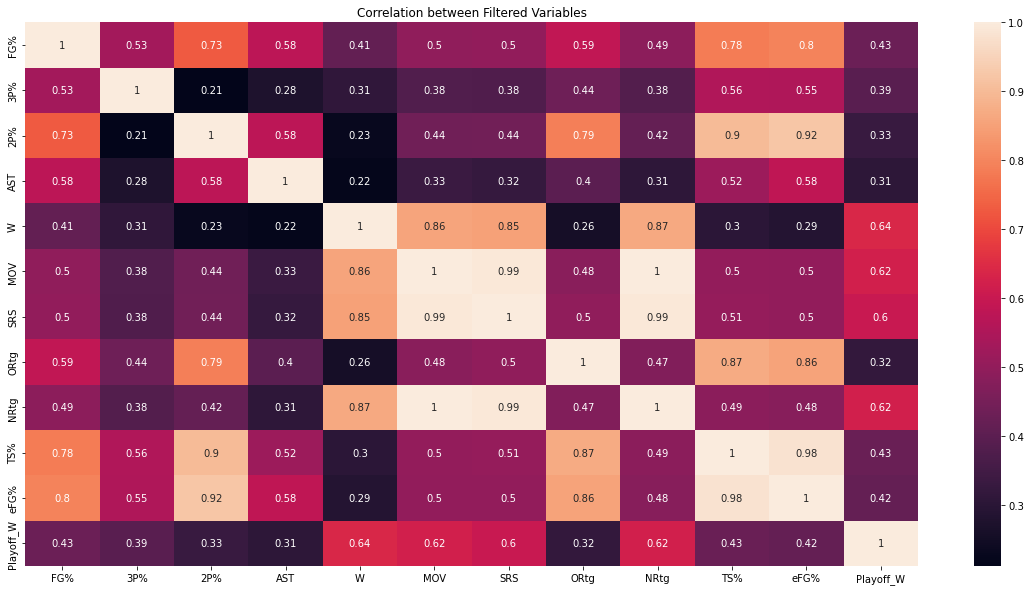

In [5]:
plt.figure(figsize=(20,10))
plt.title("Correlation between Filtered Variables")
sns.heatmap(data=data[variables].corr(), annot=True)

In [6]:
# Exporting correlation table for graph 3
# HOWEVER, given these values are for the 2013-2021 seasons, they will not change. 
# As such, no need to overwrite the CSV each time the model is run

# var_heatmap = variables.copy()
# var_heatmap.append('Adjusted Payroll')
# df_correlations = data[var_heatmap].corr().reset_index(level=0).rename(columns={"Playoff_W": "P_W", "Adjusted Payroll": "Pay"}).replace({"Playoff_W": "P_W", "Adjusted Payroll": "Pay"})

# df_correlations = df_correlations.melt('index', var_name='Variable', value_name='Correlation')
# df_correlations.to_csv('C:/Users/whisk/OneDrive/Documents/Bristol/Economics/Year 4/Data Science/slblundell.github.io/nba_project/data/correlations_playoff.csv')

In [7]:
corr_pay = data['Playoff_W'].corr(data['Adjusted Payroll'])
corr_wins = data['W'].corr(data['Adjusted Payroll'])

print(f'Correlation between playoff wins and payrolls: {corr_pay}')
print(f'Correlation between regular season wins and payrolls: {corr_wins}')

Correlation between playoff wins and payrolls: 0.1314894673790181
Correlation between regular season wins and payrolls: -0.02095894928149344


In [8]:
# removing MOV (margin of victory) as this variable causes multicolinearity concerns with SRS (Simple Rating System)
# additionally, removing Adjusted Payroll given we do not want payroll to factor into the linear regression when
# comparing predicted playoff rating with payrolls
remove = ['MOV','Adjusted Payroll']
variables = [item for item in variables if item not in remove]
variables

['FG%',
 '3P%',
 '2P%',
 'AST',
 'W',
 'SRS',
 'ORtg',
 'NRtg',
 'TS%',
 'eFG%',
 'Playoff_W']

In [9]:
# creating our coefficient matrices
X = data[variables].drop('Playoff_W',1)
Y = data['Playoff_W']

pred_X = pred_data[variables].drop('Playoff_W',1)

X.head()

C:\Users\whisk\AppData\Local\Temp\ipykernel_6040\3068187647.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = data[variables].drop('Playoff_W',1)
C:\Users\whisk\AppData\Local\Temp\ipykernel_6040\3068187647.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pred_X = pred_data[variables].drop('Playoff_W',1)


,FG%,3P%,2P%,AST,W,SRS,ORtg,NRtg,TS%,eFG%
0,0.478,0.343,0.516,24.4,57.0,5.37,110.4,5.3,0.549,0.515
1,0.461,0.366,0.511,23.2,45.0,3.69,109.7,3.6,0.564,0.525
2,0.481,0.377,0.514,21.4,60.0,9.15,112.4,9.8,0.580,0.527
3,0.481,0.376,0.519,25.1,58.0,6.67,108.3,6.7,0.568,0.531
4,0.496,0.396,0.536,23.0,66.0,7.03,112.3,8.6,0.588,0.552


In [10]:
# creating our test split, with a size of 20% of the data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# training our model
model = LinearRegression().fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [11]:
# explore model performance
print('Coefficients: ', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared erorr: %.2f' 
    % mean_squared_error(Y_test, Y_pred))
print('Coefficient of determination (R^2): %.2f' 
    % r2_score(Y_test, Y_pred))

Coefficients:  [-37.26955731  26.60020004  -9.67298037   0.14608649   0.35788624
  -2.00026111  -0.11116312   1.93409321  33.89510881  58.45119839]
Intercept: -40.85357187094187
Mean squared erorr: 12.46
Coefficient of determination (R^2): 0.41


c:\Users\whisk\miniconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Playoff_W'>

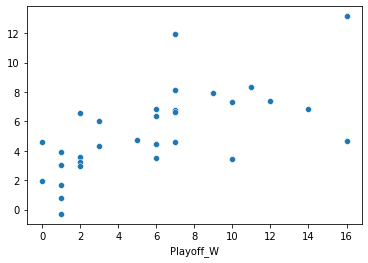

In [12]:
# scatter plot of our predicted playoff wins vs actual playoff wins
sns.scatterplot(Y_test, Y_pred)

In [13]:
# defining the linear regression model
Y_pred = model.predict(pred_X)

# normalizing the predicted playoff wins, to prevent teams being predicted "negative wins" due to the fact the 2022/23
# season has yet to end (in addition to aiding interpretation)
w_min, w_max = min(Y_pred), max(Y_pred)
for i, win in enumerate(Y_pred):
    Y_pred[i] = (win-w_min) / (w_max - w_min)

Y_pred

array([0.94458868, 0.59880657, 0.60252373, 0.63581273, 0.5069796 ,
       0.75941913, 1.        , 0.34268012, 0.51048303, 0.68982666,
       0.34401144, 0.39864514, 0.57774908, 0.94458981, 0.45954126,
       0.82219138, 0.52402927, 0.60375783, 0.59168579, 0.61554131,
       0.25680505, 0.24195461, 0.00889811, 0.06509248, 0.71721885,
       0.04015702, 0.29880521, 0.68472874, 0.        , 0.48626958])

In [14]:
# creating DataFrame of normalized predicted playoff wins (so-called predicted playoff rating) for 2022/23 season
df_Y_pred = pred_data[['Team','Playoff_W']]
 
for i in range(30):
    df_Y_pred.loc[i, 'Playoff_W'] = Y_pred[i]

df_Y_pred = df_Y_pred.sort_values(by='Playoff_W',ascending=False).reset_index(drop=True)
df_Y_pred = df_Y_pred.rename(columns={'Playoff_W': 'Predicted Playoff Rating'})
df_Y_pred

C:\Users\whisk\AppData\Local\Temp\ipykernel_6040\1039064921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Y_pred.loc[i, 'Playoff_W'] = Y_pred[i]


,Team,Predicted Playoff Rating
0,Denver Nuggets,1.000000
1,Brooklyn Nets,0.944590
2,Boston Celtics,0.944589
3,Philadelphia 76ers,0.822191
4,Golden State Warriors,0.759419
5,Cleveland Cavaliers,0.717219
6,Indiana Pacers,0.689827
7,Los Angeles Clippers,0.684729
8,New Orleans Pelicans,0.635813
9,Portland Trail Blazers,0.615541


In [15]:
# merging predicted playoff wins DataFrame with Payroll data for comparison
payroll = pred_data[['Team', 'Payroll']]
df_Y_pred = pd.merge(df_Y_pred, payroll, on='Team')
df_Y_pred

,Team,Predicted Playoff Rating,Payroll
0,Denver Nuggets,1.000000,162893770
1,Brooklyn Nets,0.944590,187611872
2,Boston Celtics,0.944589,178639335
3,Philadelphia 76ers,0.822191,152458779
4,Golden State Warriors,0.759419,193374102
5,Cleveland Cavaliers,0.717219,150510719
6,Indiana Pacers,0.689827,97936376
7,Los Angeles Clippers,0.684729,192300473
8,New Orleans Pelicans,0.635813,147711891
9,Portland Trail Blazers,0.615541,150754415


In [16]:
df_Y_pred.to_csv('C:/Users/whisk/OneDrive/Documents/Bristol/Economics/Year 4/Data Science/slblundell.github.io/nba_project/data/model_predicted_wins.csv')

In [17]:
corr_pred = df_Y_pred['Predicted Playoff Rating'].corr(df_Y_pred['Payroll'])
print(f'Correlation between predicted playoff rating and payrolls: {corr_pred}')

Correlation between predicted playoff rating and payrolls: 0.5287930588308556


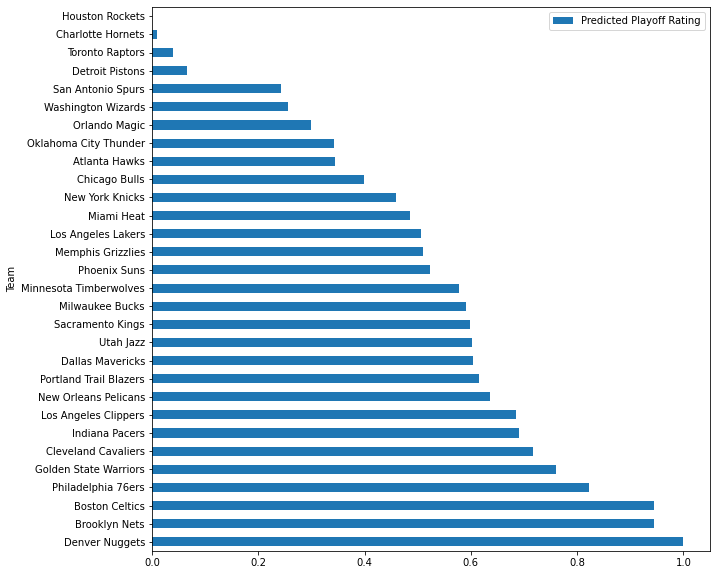

In [18]:
ax = df_Y_pred.plot.barh(x='Team', y='Predicted Playoff Rating', figsize=(10,10))

In [19]:
fig = ax.get_figure()
fig.savefig('C:/Users/whisk/OneDrive/Documents/Bristol/Economics/Year 4/Data Science/slblundell.github.io/nba_project/figures/win_rating_bar.jpeg')